# Loan Prediction Based on Customer Profile
In this notebook we will load a dataset consisting of customer profiles and loan default behavior. We will create some visualizations to get a better understanding of the different types of customers and how their characteristics can relate to the loan default status. Lastly we will then check if the various customer characteristics are a good indicator of loan default behavior by using a decision trees algorithm to predict default status for any given customer.

Let's first load required libraries:

In [246]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

### About This Dataset
This dataset consists of customer information with various attributes such as age, education, employment, etc along with default status. These records can be used to reliably calculate credit risk based on customer characteristics.

Credit scoring is a classic use-case for predictive modeling. Machine learning can be leveraged to predict whether or not credit extended to an applicant will likely result in profit or losses for the lending institution. Credit scoring is complex and there are various intricancies in determining how exactly credit is extended to individuals, businesses, and other organizations, But in all cases, the lender provides credit to individuals or organizations with an expectation to be paid back in time with interest commensurate with the risk of default. The default risk can be measured by taking into consideration a myriad of factors as we will attempt to uncover with this project.

**Potential Business Applications:**
- Marketing: Understand customer demographics
- Credit Risk Evaluation: Predict default risk based on customer profiles


### Data Import & Review

In [247]:
df = pd.read_csv('bankloans.csv')
df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1150 non-null   int64  
 1   ed        1150 non-null   int64  
 2   employ    1150 non-null   int64  
 3   address   1150 non-null   int64  
 4   income    1150 non-null   int64  
 5   debtinc   1150 non-null   float64
 6   creddebt  1150 non-null   float64
 7   othdebt   1150 non-null   float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 81.0 KB


Our dataset has 1150 records, and 9 feature columns. Note that the "default" column has null values:

In [249]:
df[df.isnull().any(axis=1)].head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


As these are the values that we are going to attempt to predict, these records provide no use so we will drop them.

In [250]:
df = df.dropna()

# Data Visualization
Here we will create some visualizations to get a better understanding of the dataset. We will start with seeing how many of each class is in our data set

In [251]:
# set visualiztion style
sns.set_theme(style="darkgrid")

### Loan Status

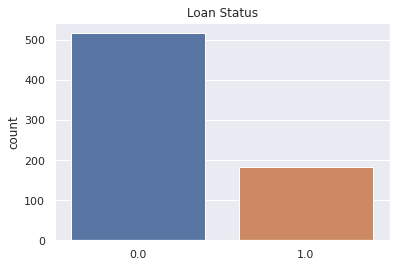

In [252]:
ax = sns.countplot(x='default', data=df).set(xlabel=None, title = 'Loan Status') 
plt.show()

In regards to loan defaults, note that 0 = False, 1 = True. Most of the customers paid off their loans but there is still a significant portion with defaulted loans.

### Customer Demographics
Next we will take a look at the demographics of the customer base pertaining to this dataset.

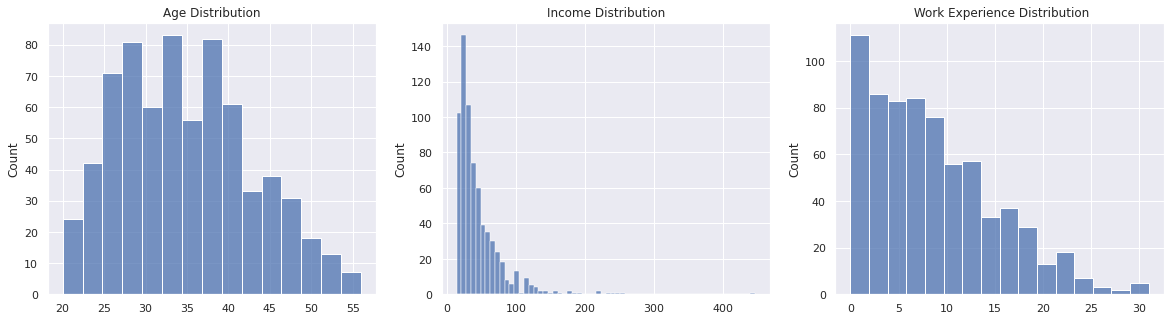

In [253]:
# create subplots to display results side by side
fig, ax =plt.subplots(1,3, figsize=(20, 5))

# Visualize value counts of age column
sns.histplot(x='age', data=df, ax=ax[0]).set(xlabel=None, title = 'Age Distribution') 

# Visualize value counts of income column # to do  update to exclude outliers
sns.histplot(x='income', data=df, ax=ax[1]).set(xlabel=None, title = 'Income Distribution') 

# Visualize value counts of experience column
sns.histplot(x='employ', data=df, ax=ax[2]).set(xlabel=None, title = ' Work Experience Distribution') 

plt.show()

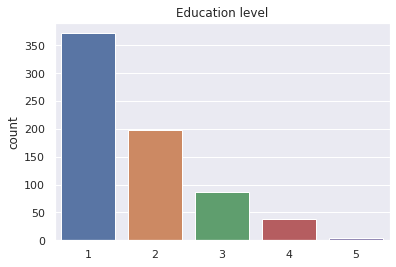

In [254]:
ax = sns.countplot(x='ed', data=df).set(xlabel=None, title = 'Education level') 
plt.show()

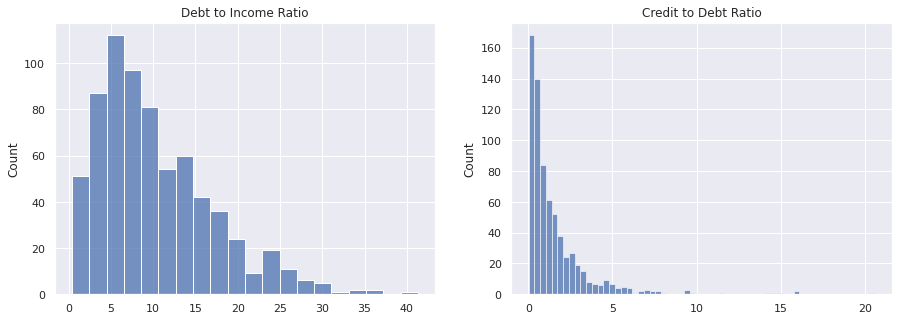

In [255]:
fig, ax =plt.subplots(1,2, figsize=(15, 5))
sns.histplot(x='debtinc', data=df, ax=ax[0]).set(xlabel=None, title = 'Debt to Income Ratio') 
sns.histplot(x='creddebt', data=df, ax=ax[1]).set(xlabel=None, title = 'Credit to Debt Ratio') 
plt.show()

Taking a deeper look into the relationship between age, education level, and loan status. Each chart below represents an education level. Within each chart, a histogram of customers plotted by age, and within each age bin is the proportion of defaulted loans (orange). Plotted against a logarithmic scale.

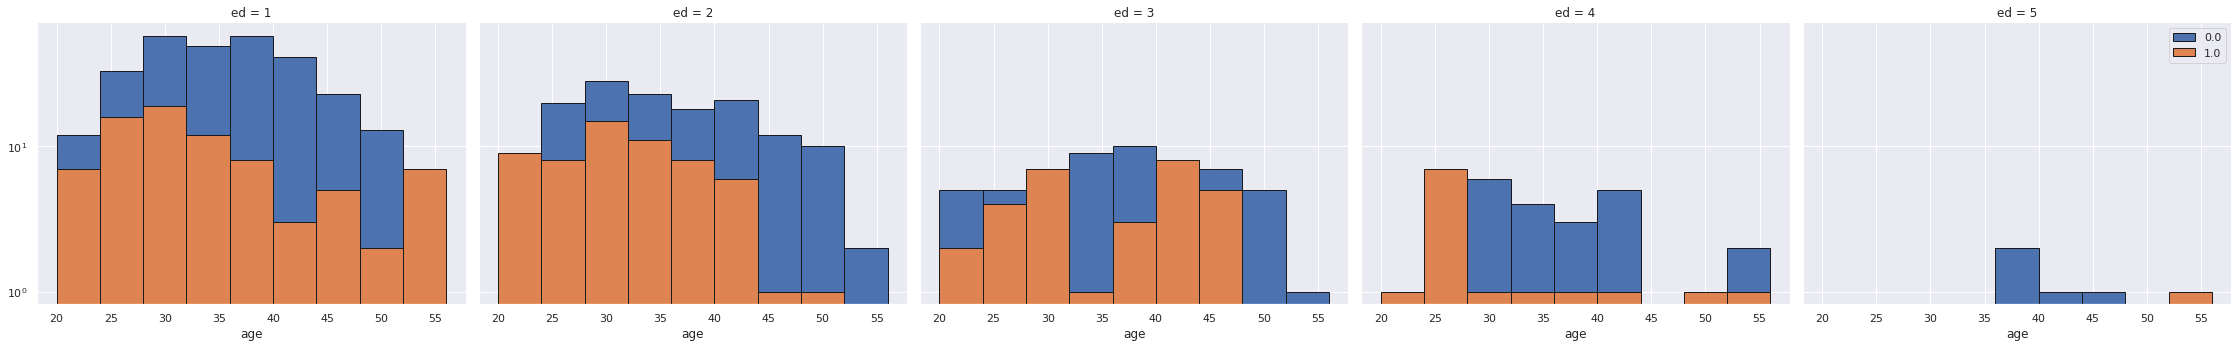

In [256]:
bins = np.linspace(df['age'].min(), df['age'].max(), 10)
g = sns.FacetGrid(df, col='ed', hue='default', col_wrap=5, height=5, aspect=1.25)
g.map(plt.hist, 'age', bins=bins, ec="k", log=True)
g.axes[-1].legend()
plt.show()

Generally, older customers are more likely to pay their loans.

# Pre-Processing:  Feature Selection & Extraction

### Feature Selection
for our features we will utilize all columns except the "default"

In [257]:
X = df.loc[:, df.columns != 'default']
#Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
X.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt
0,41,3,17,12,176,9.3,11.359392,5.008608
1,27,1,10,6,31,17.3,1.362202,4.000798
2,40,1,15,14,55,5.5,0.856075,2.168925
3,41,1,15,14,120,2.9,2.658720,0.821280
4,24,2,2,0,28,17.3,1.787436,3.056564


and we will use default column as y

In [258]:
y = df['default'].values

### Data Normalization
Normalizing the data to get ready for modeling:

In [259]:
X= preprocessing.StandardScaler().fit(X).transform(X)

### Training and Test Set Split
In order to evaluate the model, we will split the dataset into a training set which we will train the model on, and a test set which will be used to evaluate the models accuracy. Luckily sklearn has a built in feature to do this.

In [260]:
# create train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (560, 8) (560,)
Test set: (140, 8) (140,)


# Using Sklearn Decision-Trees Algorithm to Predict Loan Status
We will continute to use the sklearn library to build a decison tree model to predict loan defaults.

In [261]:
# Import sklearn
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

### Parameter Tuning
To ensure we have the best depth parameter for the model, we will test with various depths to see which has the highest accuracy.

In [267]:
# parameter tuning to find best depth value
Ks = 50
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train Model and Predict  
    dTree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    y_pred= dTree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)    
    std_acc[n-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])

### Parameter Tuning: Visualized

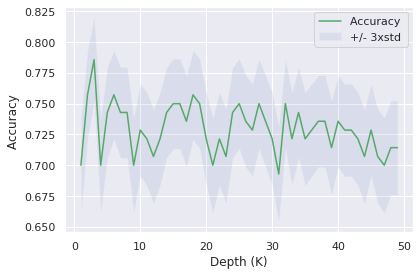

In [263]:
# parameter tuning visualization
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth (K)')
plt.tight_layout()
plt.show()

### Final Model

It looks like a depth of 3 gives us the best accuracy score, so we will use that.

In [264]:
final_dTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3).fit(X_train,y_train)

### Decision Tree Visualization

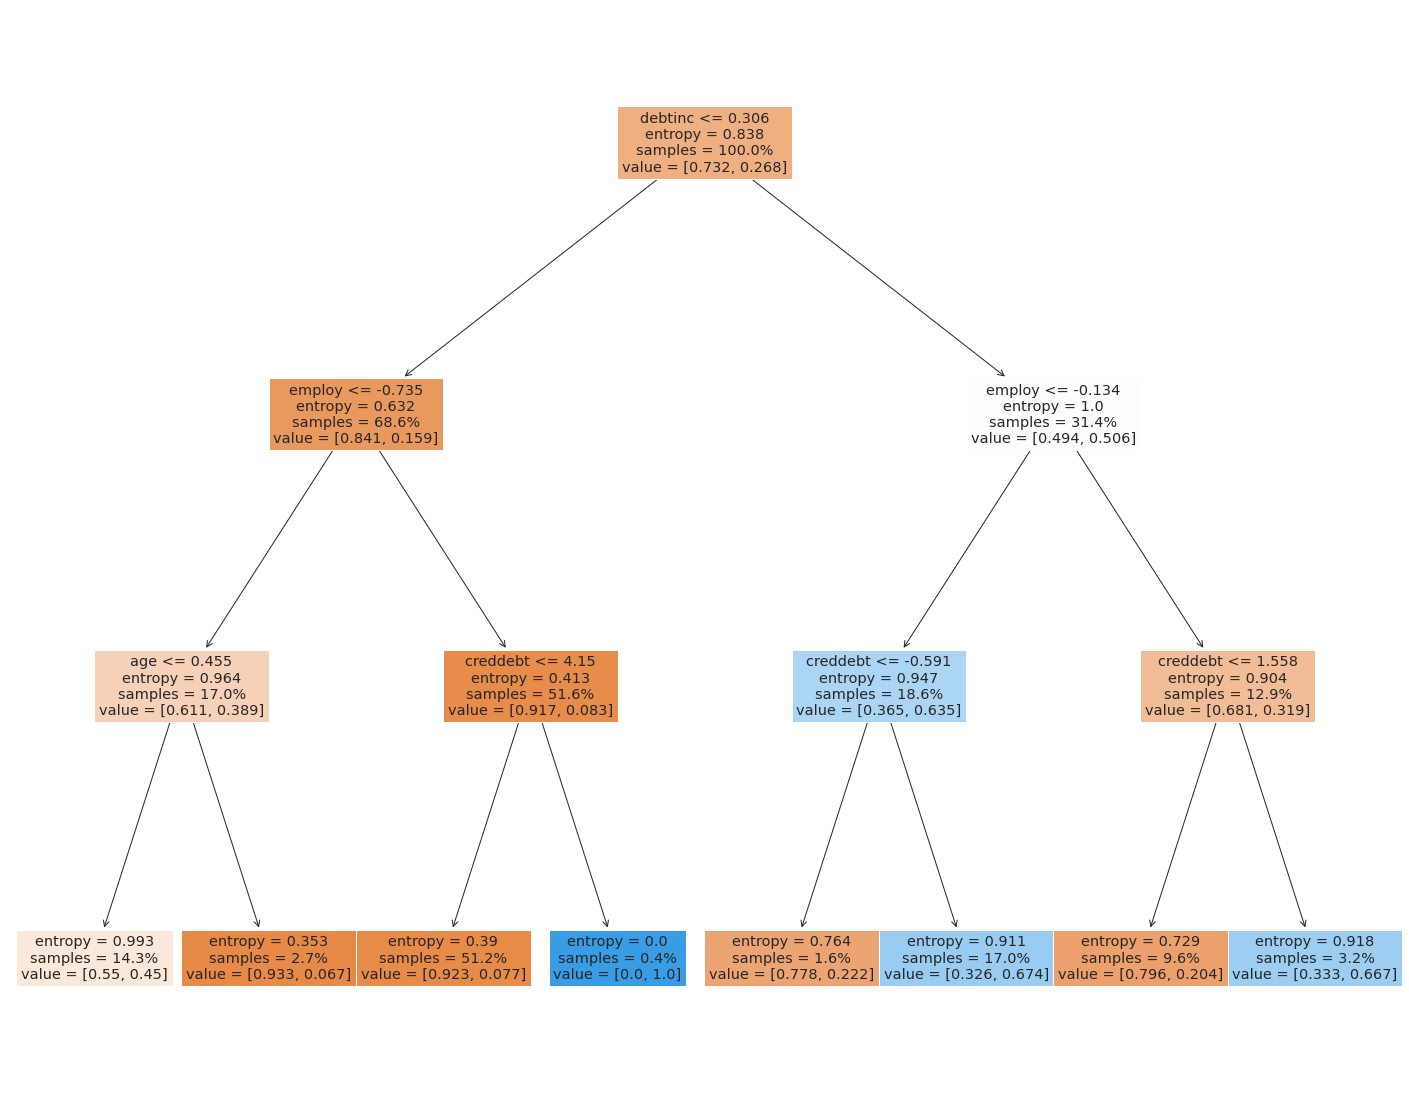

In [265]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(final_dTree, 
                   feature_names=Feature.columns,
                   proportion =True,
                   filled=True)

# Results

In [266]:
# Apply model to testing set features to predict loan status
y_pred = final_dTree.predict(X_test)

# Evaluate predictions results
metrics.accuracy_score(y_test, y_pred)

0.7857142857142857

With an accuracy score of .78, the model is fairly accurate in predicting default risk when given a feature set (profile) of customers.